# This notebook is for Mahalanobis distance (multiple sensors) results on train & two test sets (normal & faulty vehicle) for smooth road surface

In [5]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import os
import math
import csv

# Import and read train (subset of Feb - normal vehicle) set

In [78]:
data_vib1 = pd.read_csv("Input_Data_Files/SmoothDataTrain.csv", index_col=0)
data_vib1

,FR_LH [m/s2],FR_RH [m/s2],RR_LH [m/s2],RR_RH [m/s2],Cabin [m/s2]
DateTime,,,,,
2020-02-25 16:44:05.545,0.100473,0.292175,-1.257048,-2.306725,0.057444
2020-02-25 16:44:05.550,0.751109,0.805315,-1.192182,-2.509827,-0.368753
2020-02-25 16:44:05.555,-0.395714,-0.780379,-1.384547,-2.121707,-1.137764
2020-02-25 16:44:05.560,-1.351551,-0.489236,-1.609597,-2.620094,-0.982462
2020-02-25 16:44:05.565,-0.074189,-0.203695,-1.431848,-2.502993,0.066187
...,...,...,...,...,...
2020-02-25 15:22:49.850,0.165165,-0.074006,-0.535016,1.069233,0.866391
2020-02-25 15:22:49.855,-0.223721,0.647041,-0.746756,0.860075,0.863193
2020-02-25 15:22:49.860,0.817461,0.130095,-0.769459,0.078495,0.577989


In [65]:
data_vib1.describe()

,FR_LH [m/s2],FR_RH [m/s2],RR_LH [m/s2],RR_RH [m/s2],Cabin [m/s2]
count,105928.000000,105928.000000,105928.000000,105928.000000,105928.000000
mean,0.568561,0.260622,-0.122829,0.305392,0.042237
std,0.914371,0.644820,0.811869,0.957511,0.561691
min,-4.223201,-3.922446,-3.642970,-3.159925,-4.687729
25%,-0.066987,-0.158810,-0.726075,-0.485360,-0.321963
50%,0.531685,0.266492,-0.219301,0.465332,0.041317
75%,1.151672,0.683819,0.451449,1.065117,0.409780
max,5.016647,6.111707,3.327065,3.390950,4.699691


array([<AxesSubplot:xlabel='DateTime'>, <AxesSubplot:xlabel='DateTime'>,
       <AxesSubplot:xlabel='DateTime'>, <AxesSubplot:xlabel='DateTime'>,
       <AxesSubplot:xlabel='DateTime'>], dtype=object)

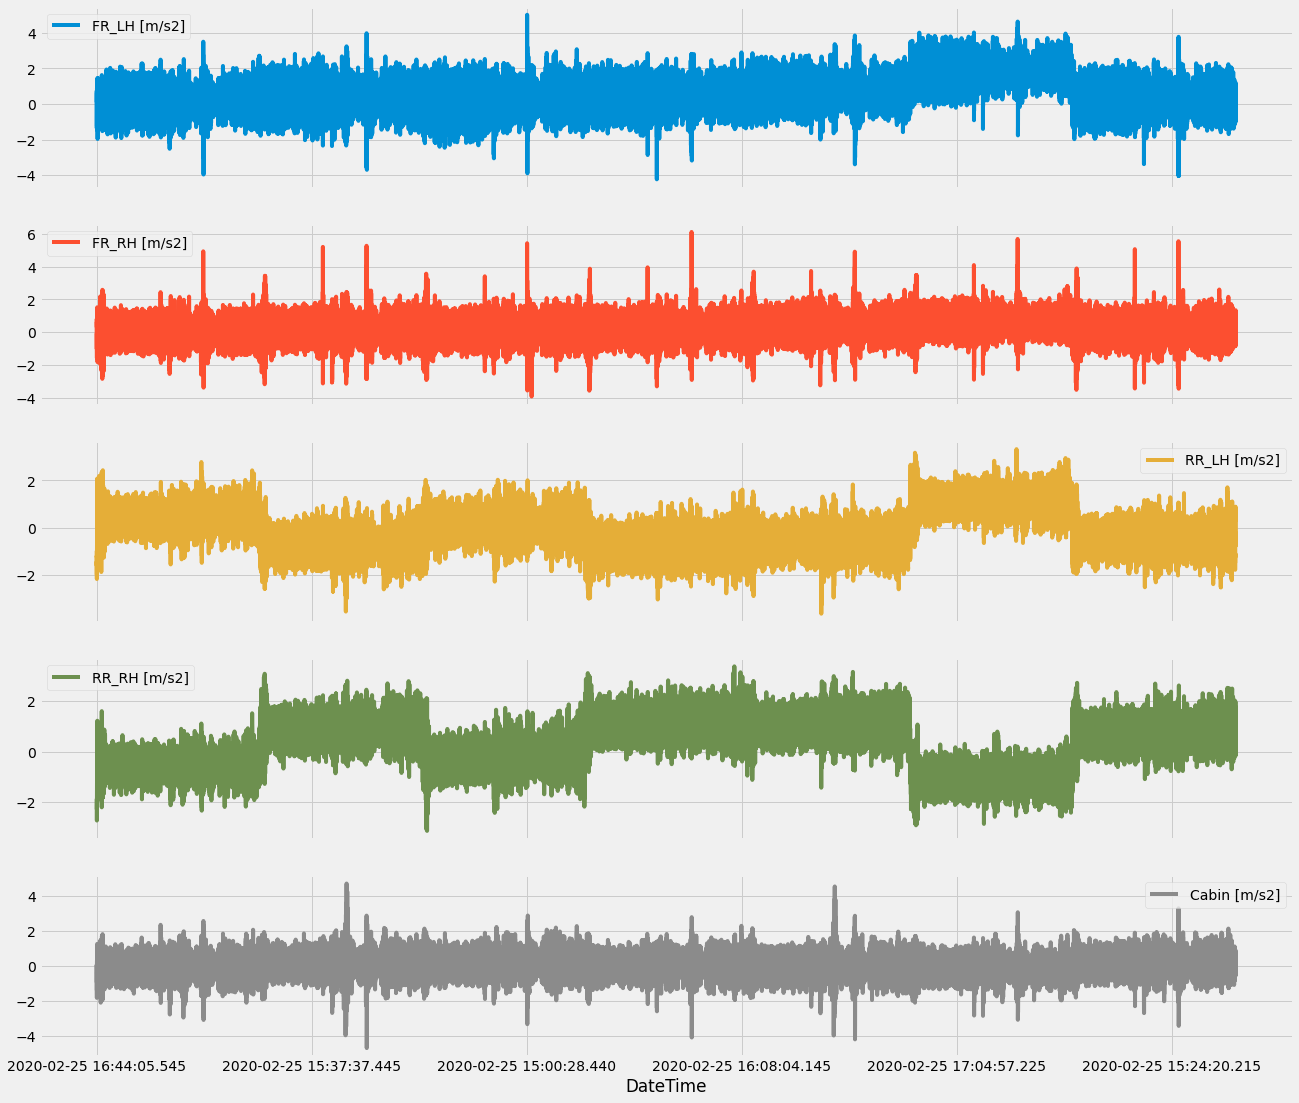

In [66]:
plt.style.use('fivethirtyeight')
data_vib1.plot(figsize=(20,18), subplots=True)

# Time domain feature extraction (7 features) function

In [67]:
def time_domain_features(test1,w,overlap):
    columns = test1.columns
    for c in range (len(columns)):
        for i in range(0,test1.shape[0]-(w-1),overlap):
            test1.loc[test1.index[i+w-1],'mean_'+str(c)] = test1.iloc[i:i+w,c].mean()
            test1.loc[test1.index[i+w-1],'var_'+str(c)] = test1.iloc[i:i+w,c].var()
            test1.loc[test1.index[i+w-1],'skew_'+str(c)] = test1.iloc[i:i+w,c].skew()
            test1.loc[test1.index[i+w-1],'kurtosis_'+str(c)] = test1.iloc[i:i+w,c].kurtosis()
            test1.loc[test1.index[i+w-1],'peak_'+str(c)] = np.max(np.abs(test1.iloc[i:i+w,c]))
            test1.loc[test1.index[i+w-1],'rms_'+str(c)] = np.sqrt(np.mean(np.square(test1.iloc[i:i+w,c])))
            test1.loc[test1.index[i+w-1],'crest_'+str(c)] = (np.max(np.abs(test1.iloc[i:i+w,c])))/(np.sqrt(np.mean(np.square(test1.iloc[i:i+w,c]))))   
    return (test1)

# Feature extraction (7 features for each sensor) of train set (total 35 features)

In [68]:
data_vib2 = time_domain_features(data_vib1,2000,250)
data_vib2 = data_vib2.dropna()
data_vib2

,FR_LH [m/s2],FR_RH [m/s2],RR_LH [m/s2],RR_RH [m/s2],Cabin [m/s2],mean_0,var_0,skew_0,kurtosis_0,peak_0,...,peak_3,rms_3,crest_3,mean_4,var_4,skew_4,kurtosis_4,peak_4,rms_4,crest_4
DateTime,,,,,,,,,,,,,,,,,,,,,
2020-02-25 16:44:15.540,-0.606976,-0.118180,0.142326,-0.559365,0.109114,0.088569,0.518666,0.026776,-0.714669,2.034943,...,2.747960,0.729674,3.766013,-0.067681,0.334906,-0.065048,0.214574,2.097860,0.582511,3.601408
2020-02-25 16:44:16.790,1.516107,1.119476,1.238472,0.162414,0.547668,0.091361,0.546558,0.086355,-0.748769,2.105665,...,2.222280,0.670379,3.314961,-0.062805,0.320670,-0.076331,0.299691,2.097860,0.569609,3.682981
2020-02-25 16:44:18.040,1.141487,0.438286,0.197672,-0.821343,0.088803,0.085013,0.568842,0.111438,-0.727672,2.105665,...,1.838765,0.645250,2.849694,-0.062942,0.248047,-0.051382,0.173272,1.960294,0.501881,3.905890
2020-02-25 16:44:19.290,0.240572,-0.496513,0.019670,-0.379183,0.566629,0.079512,0.598167,0.133355,-0.832147,2.105665,...,1.735353,0.628175,2.762529,-0.061912,0.198001,0.004027,-0.336908,1.330635,0.449149,2.962566
2020-02-25 16:44:20.540,-1.003657,-0.565174,0.100121,-0.426663,0.021848,0.075214,0.608358,0.130211,-0.855410,2.105665,...,1.735353,0.638736,2.716855,-0.064391,0.199719,-0.001291,-0.347107,1.330635,0.451404,2.947769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-25 15:26:08.890,1.295201,0.370314,0.057368,1.027073,-0.162591,0.311812,0.411934,0.011722,-0.239245,2.312914,...,2.371321,1.018179,2.328983,0.193613,0.317009,-0.003568,-0.172813,1.899880,0.595261,3.191674
2020-02-25 15:26:10.140,0.922997,0.625828,-1.165478,0.817159,-0.462084,0.307666,0.438854,0.009250,-0.368325,2.312914,...,2.371321,1.007193,2.354385,0.186696,0.333823,0.017616,-0.340550,1.899880,0.607051,3.129685
2020-02-25 15:26:11.390,1.591766,1.430832,-0.133228,1.451949,2.129344,0.292680,0.452775,0.027453,-0.298196,2.312914,...,2.535017,1.008678,2.513208,0.172125,0.331358,0.111931,-0.226380,2.129344,0.600682,3.544876


                           mean_0     var_0    skew_0  kurtosis_0    peak_0  \
DateTime                                                                      
2020-02-25 16:44:15.540  0.088569  0.518666  0.026776   -0.714669  2.034943   
2020-02-25 16:44:16.790  0.091361  0.546558  0.086355   -0.748769  2.105665   
2020-02-25 16:44:18.040  0.085013  0.568842  0.111438   -0.727672  2.105665   
2020-02-25 16:44:19.290  0.079512  0.598167  0.133355   -0.832147  2.105665   
2020-02-25 16:44:20.540  0.075214  0.608358  0.130211   -0.855410  2.105665   

                            rms_0   crest_0    mean_1     var_1    skew_1  \
DateTime                                                                    
2020-02-25 16:44:15.540  0.725432  2.805147  0.052806  0.491262 -0.257778   
2020-02-25 16:44:16.790  0.744736  2.827399  0.058583  0.468080 -0.221783   
2020-02-25 16:44:18.040  0.758805  2.774975  0.061446  0.400131 -0.180909   
2020-02-25 16:44:19.290  0.777297  2.708959  0.064414  0.2737

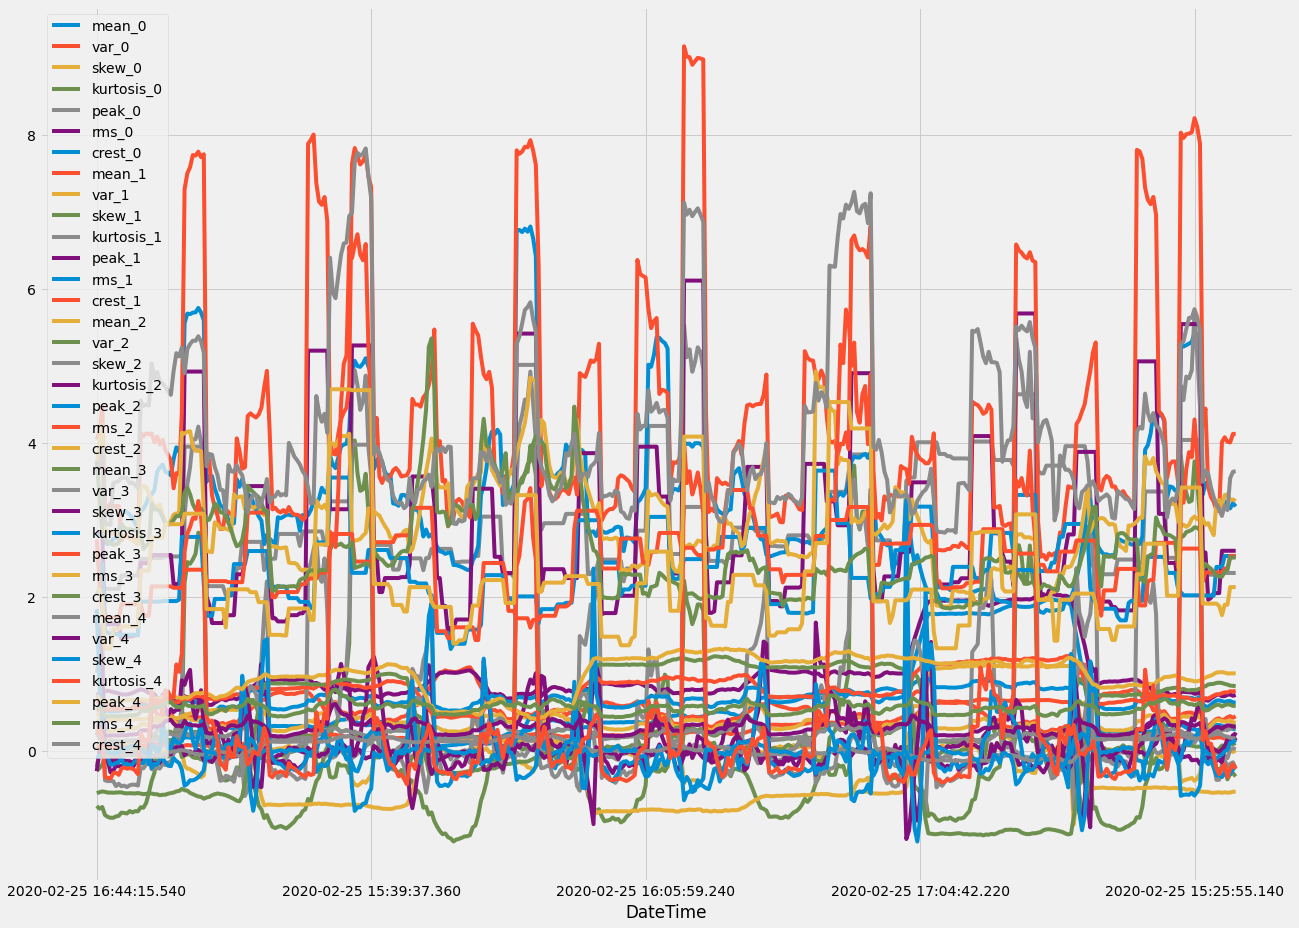

In [69]:
plt.style.use('fivethirtyeight')
data_vib = data_vib2.iloc[:,5:40]
print(data_vib.head())
data_vib.plot(figsize=(20,15))
plt.show()

In [70]:
columns = data_vib.columns
columns

Index(['mean_0', 'var_0', 'skew_0', 'kurtosis_0', 'peak_0', 'rms_0', 'crest_0',
       'mean_1', 'var_1', 'skew_1', 'kurtosis_1', 'peak_1', 'rms_1', 'crest_1',
       'mean_2', 'var_2', 'skew_2', 'kurtosis_2', 'peak_2', 'rms_2', 'crest_2',
       'mean_3', 'var_3', 'skew_3', 'kurtosis_3', 'peak_3', 'rms_3', 'crest_3',
       'mean_4', 'var_4', 'skew_4', 'kurtosis_4', 'peak_4', 'rms_4',
       'crest_4'],
      dtype='object')

# Feature selection of train set using PCA (reduced to 10 features)

Text(0.5, 1.0, 'PCA Explained Variance vs. N Componets')

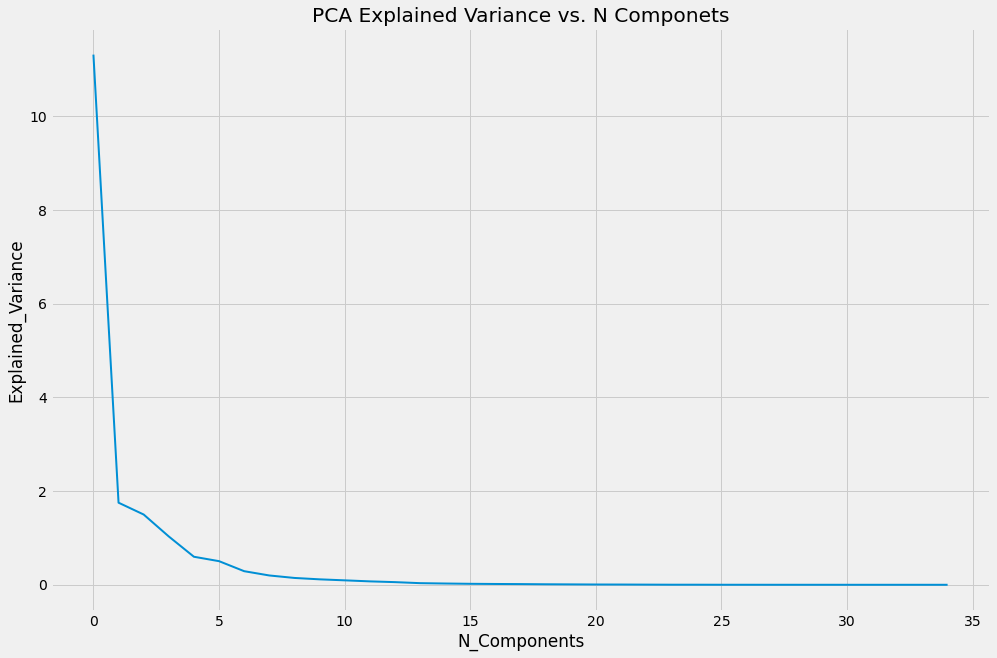

In [71]:
plt.style.use('fivethirtyeight')
from sklearn.decomposition import PCA

#find explained variance and n_components
pca = PCA()
fit = pca.fit(data_vib)
plt.figure(figsize=(15, 10))
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('N_Components')
plt.ylabel('Explained_Variance')
plt.title('PCA Explained Variance vs. N Componets')

Explained Variance: [6.34437924e-01 9.82474934e-02 8.40894303e-02 5.78220888e-02
 3.35545328e-02 2.82723327e-02 1.62811210e-02 1.11619924e-02
 8.19552209e-03 6.53264368e-03 5.32505972e-03 4.09944157e-03
 3.19048070e-03 1.96304118e-03 1.52502819e-03 1.17807878e-03
 9.76799812e-04 8.38550488e-04 6.21373335e-04 4.84560688e-04
 3.45695659e-04 3.03722318e-04 1.98644395e-04 1.00799611e-04
 9.43095670e-05 4.36698904e-05 3.54227359e-05 2.35688143e-05
 1.82852663e-05 1.48193070e-05 9.92586763e-06 6.52256938e-06
 5.55949346e-06 8.43773838e-07 7.15408867e-07]


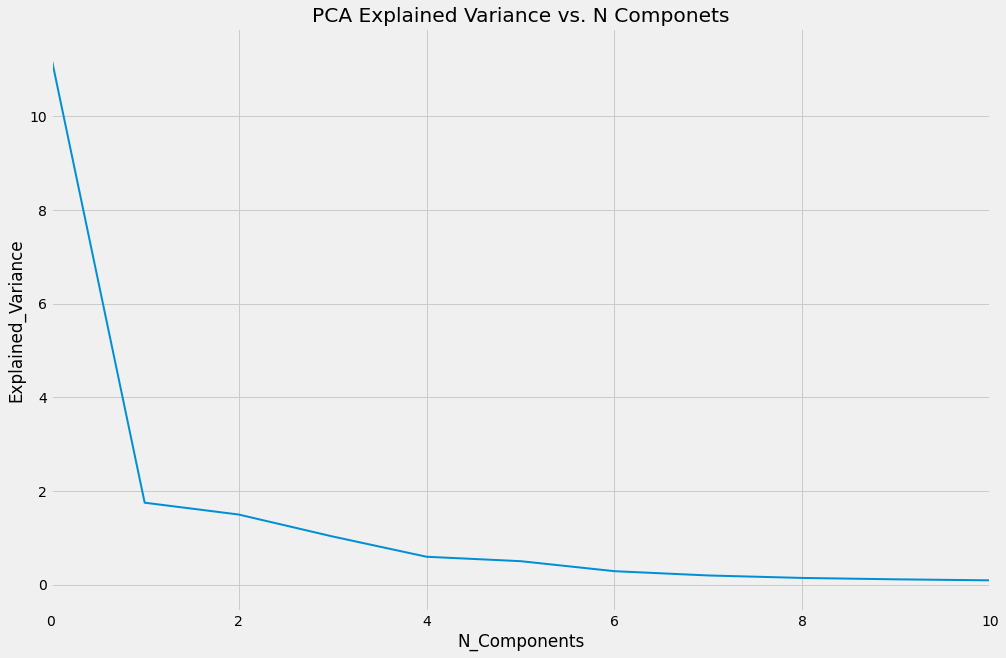

In [72]:
from sklearn.decomposition import PCA

#find explained variance and n_components
pca = PCA()
fit = pca.fit(data_vib)
plt.figure(figsize=(15, 10))
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('N_Components')
plt.ylabel('Explained_Variance')
plt.xlim(0, 10)
plt.title('PCA Explained Variance vs. N Componets')

print("Explained Variance: %s" % fit.explained_variance_ratio_)

In [73]:
pca = PCA(n_components=10)
fit = pca.fit(data_vib)
print("Explained Variance: %s" % fit.explained_variance_ratio_)
print(fit.components_)

Explained Variance: [0.63443792 0.09824749 0.08408943 0.05782209 0.03355453 0.02827233
 0.01628112 0.01116199 0.00819552 0.00653264]
[[-5.53143996e-03 -1.01165544e-02 -3.33513128e-02  3.30321089e-01
   1.30229405e-01 -1.19711924e-02  1.91365048e-01  4.99539058e-04
   1.16208949e-02  5.79172064e-03  4.47872925e-01  3.37146423e-01
   8.37557930e-03  4.37997155e-01 -2.28533226e-02  1.59012212e-03
   8.06718980e-03  4.89301015e-02  4.52878366e-02  1.37971994e-03
   5.31432087e-02  3.18261200e-02  4.54152737e-04  1.11432718e-04
   1.63974480e-02  2.54001117e-02  5.10006869e-03  1.41660772e-02
   3.78406080e-03  1.07498743e-02 -4.21749462e-02  4.25395047e-01
   2.16008965e-01  9.96008309e-03  2.99895257e-01]
 [ 3.60832779e-01 -2.62477511e-02 -6.73807575e-03  1.02323743e-01
   2.78047835e-01  2.69229387e-01 -3.46760184e-01  1.06126508e-01
  -1.66030595e-02 -1.11393016e-02  2.86653767e-02 -3.46848449e-02
   4.77122375e-02 -3.17736782e-01  3.67198714e-01 -4.70109807e-03
  -1.33925947e-02 -1.223

In [74]:
pca = PCA(n_components=10)
data_vib = pca.fit_transform(data_vib)
data_vib.shape

(416, 10)

In [75]:
data_vib = pd.DataFrame(data_vib)
data_vib.columns=['0','1','2','3','4','5','6','7','8','9']
data_vib

,0,1,2,3,4,5,6,7,8,9
0,-0.951416,-0.300912,-0.500085,1.395413,2.230120,-0.758817,1.485976,0.564785,-0.219196,-0.185599
1,-0.782511,-0.307529,-0.492145,1.274321,1.638584,-0.962313,0.861111,0.246343,0.461043,-0.536626
2,-0.506240,-0.383467,-0.759566,1.080552,1.129640,-1.199265,0.496962,0.153050,0.967893,-0.876845
3,-3.278696,-0.098847,-0.067592,1.116112,-0.680821,-0.882733,0.424127,-0.013033,0.193463,-0.279034
4,-3.289046,-0.101857,-0.101693,1.073625,-0.722954,-0.906309,0.380855,-0.032531,0.198566,-0.298716
...,...,...,...,...,...,...,...,...,...,...
411,-1.674227,-1.103902,0.139979,-0.343687,-0.100070,0.310757,-0.095760,-0.150426,0.182655,-0.590658
412,-1.879235,-1.124577,0.057337,-0.350709,0.018774,0.292519,-0.125641,-0.102300,0.184093,-0.555822
413,-1.627887,-0.995756,0.299393,-0.371976,0.094374,0.156529,-0.204974,-0.129671,-0.095683,-0.472476
414,-1.502464,-1.027076,0.314291,-0.343278,0.102221,0.139496,-0.218063,-0.059946,-0.124564,-0.485176


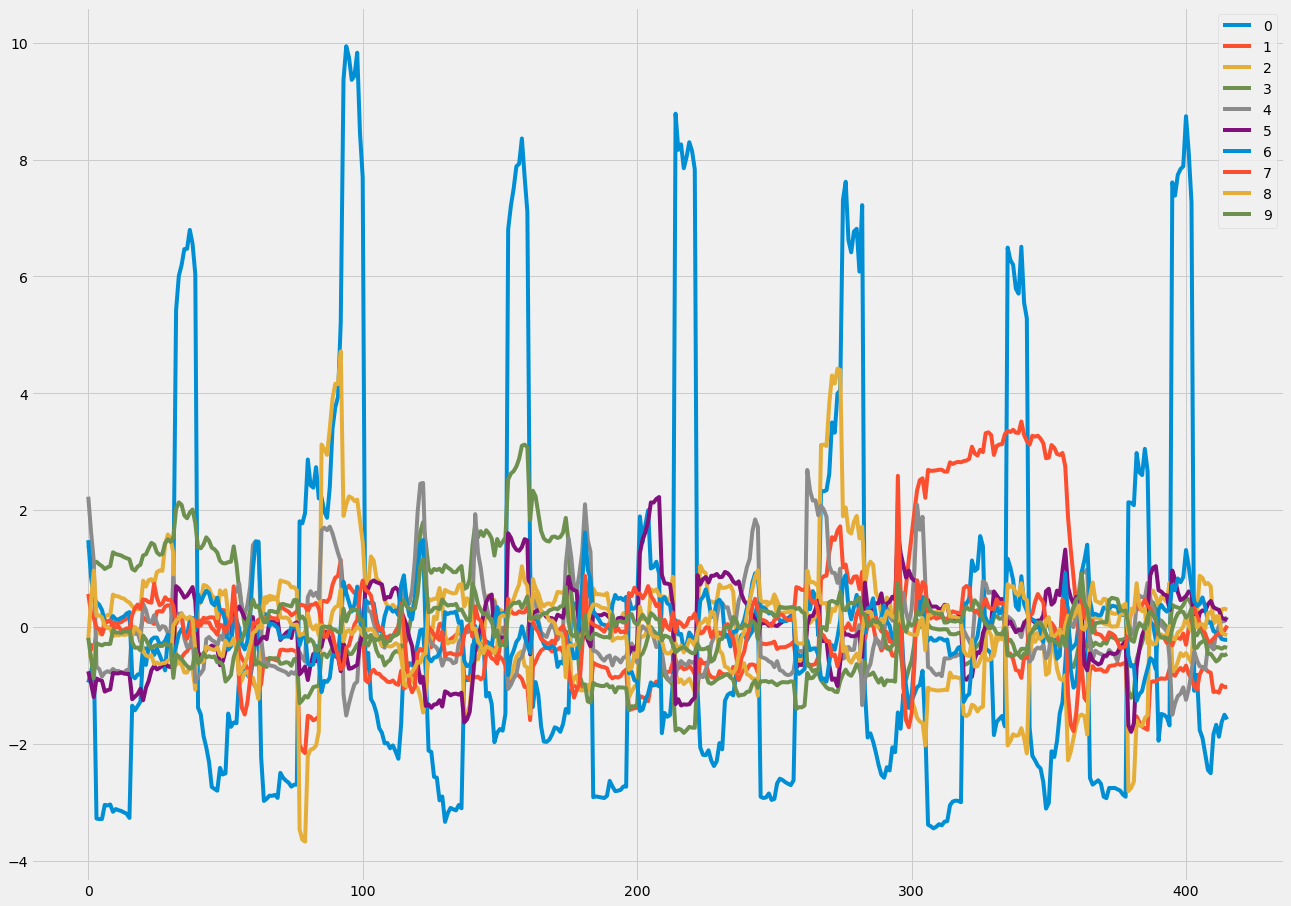

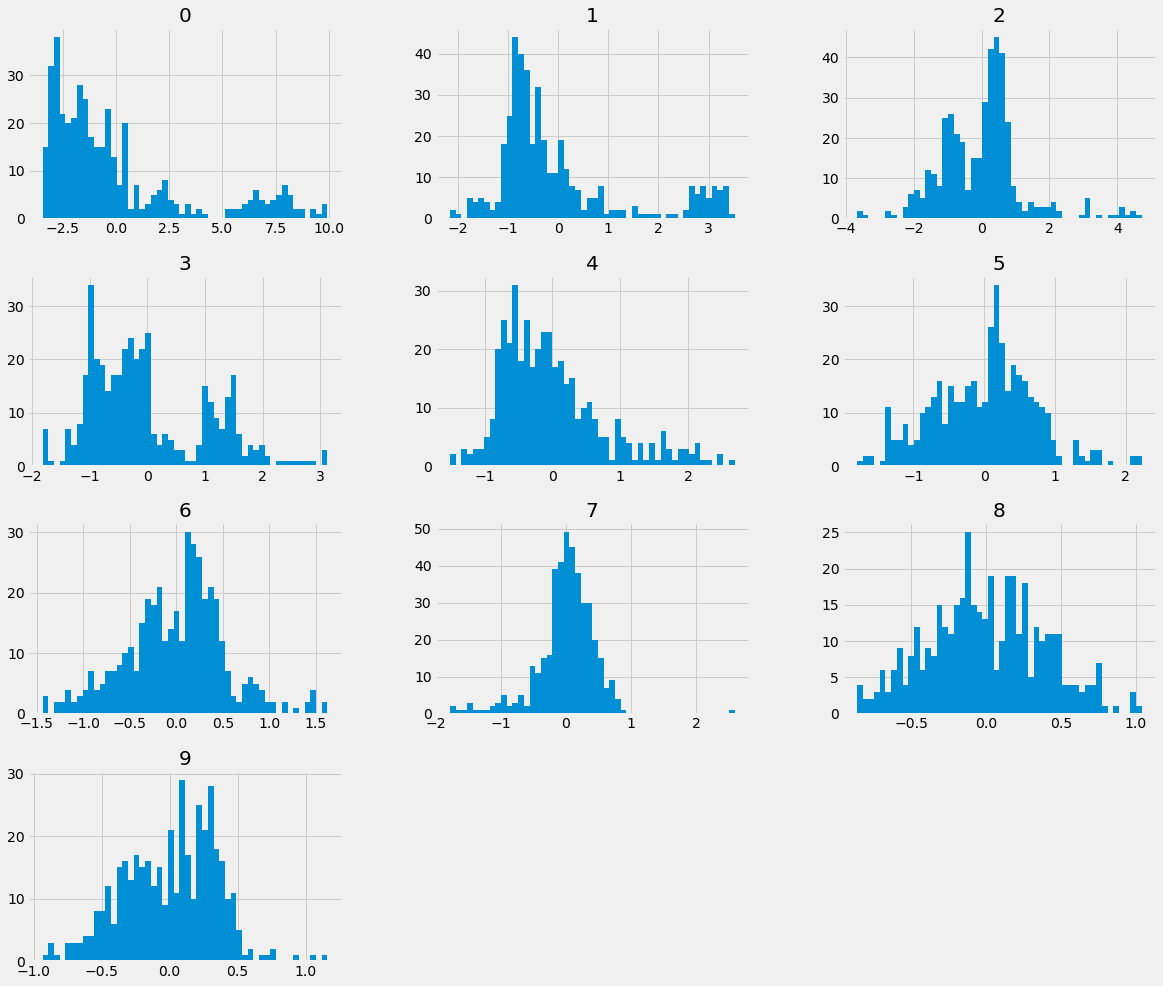

In [76]:
data_vib.plot(figsize=(20,15))
data_vib.hist(bins=50, figsize=(18,16))
plt.show()

In [79]:
plt.figure(figsize=(15, 10))
import plotly.express as px
fig = px.scatter_matrix(data_vib)
fig.show()

<Figure size 1080x720 with 0 Axes>

# Import and read test (subset of Feb - normal vehicle) set

In [80]:
data = pd.read_csv("Input_Data_Files/SmoothDataTest_Feb.csv", index_col=0)
data

,FR_LH [m/s2],FR_RH [m/s2],RR_LH [m/s2],RR_RH [m/s2],Cabin [m/s2]
DateTime,,,,,
2020-02-25 15:03:04.425,-0.757349,-0.709606,-0.639939,-0.808832,-0.829674
2020-02-25 15:03:04.430,0.619478,0.428583,-0.492601,-0.478179,0.005857
2020-02-25 15:03:04.435,1.745396,1.014770,-0.729361,-1.484268,0.453091
2020-02-25 15:03:04.440,0.062191,-0.080798,-0.539860,-0.560732,-0.123652
2020-02-25 15:03:04.445,-0.224184,-0.766837,-0.430473,-0.779751,-0.589203
...,...,...,...,...,...
2020-02-25 17:07:15.915,2.039397,1.363934,1.001291,-1.255134,-0.415626
2020-02-25 17:07:15.920,2.298627,-0.070626,0.328625,-1.718490,-0.268216
2020-02-25 17:07:15.925,1.452066,0.761699,1.373090,-1.387942,0.476310


In [37]:
data.describe()

,FR_LH [m/s2],FR_RH [m/s2],RR_LH [m/s2],RR_RH [m/s2],Cabin [m/s2]
count,120509.000000,120509.000000,120509.000000,120509.000000,120509.000000
mean,0.771191,0.315376,-0.024311,0.166633,0.043620
std,0.893403,0.641234,0.818216,0.914273,0.565499
min,-4.750211,-5.877948,-3.737362,-3.157780,-4.456687
25%,0.149365,-0.095630,-0.629282,-0.531000,-0.328484
50%,0.752769,0.318590,-0.081082,0.220407,0.043052
75%,1.369915,0.734368,0.561931,0.862535,0.414027
max,6.619570,7.047453,3.368091,3.819611,3.163019


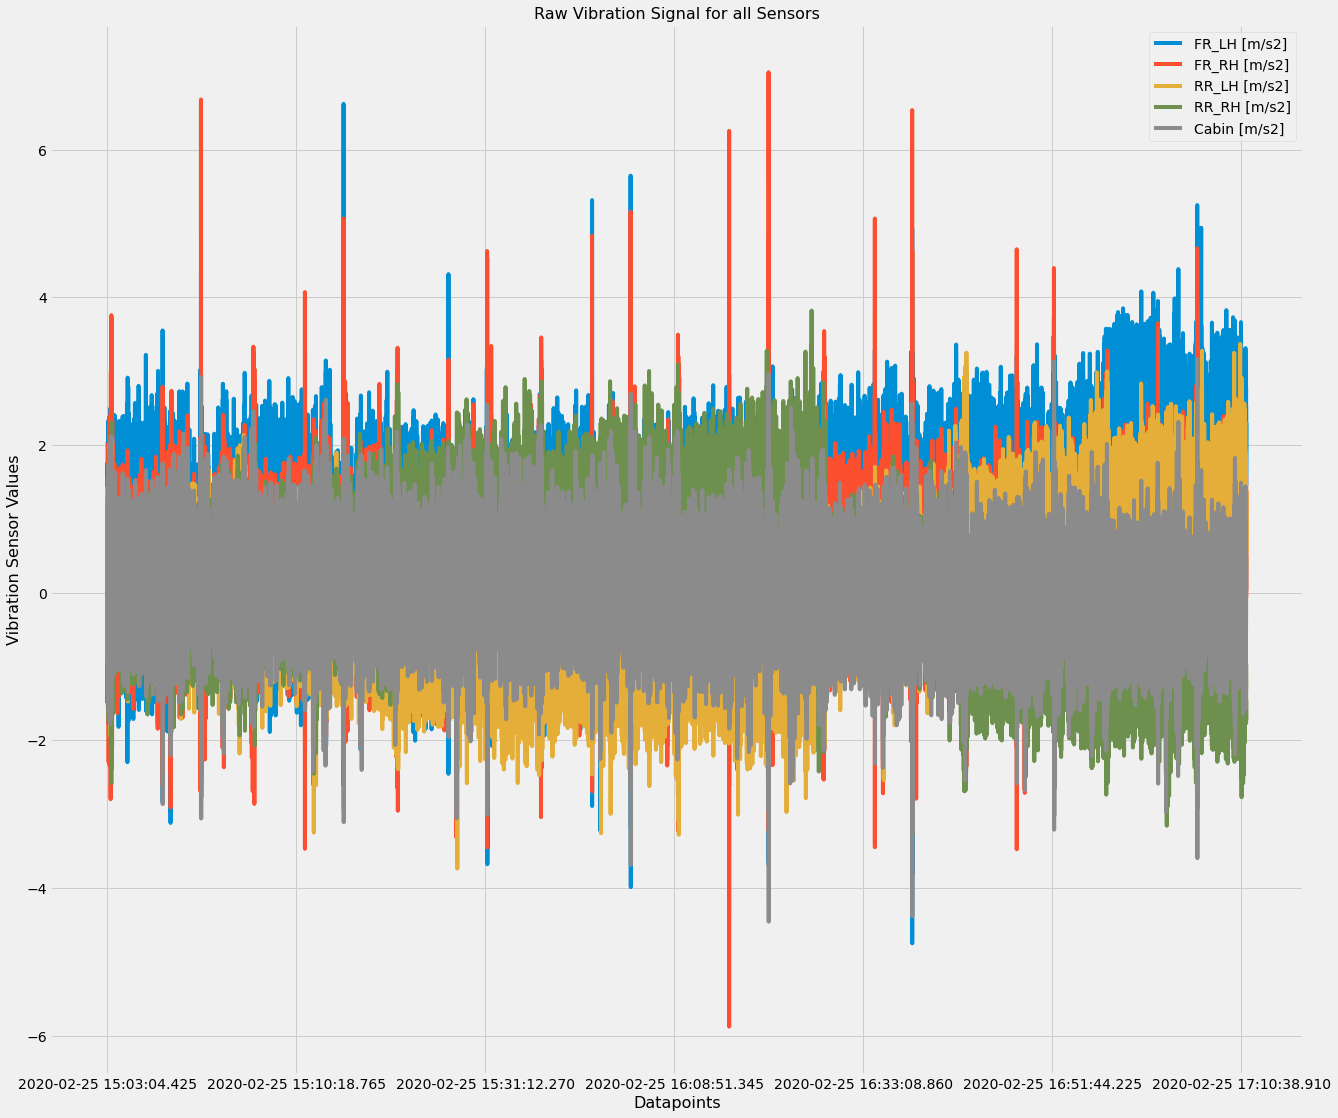

In [38]:
plt.style.use('fivethirtyeight')
ax = data.plot(figsize=(20,18), subplots=False)
ax.set_xlabel('Datapoints', fontsize=16)
ax.set_ylabel('Vibration Sensor Values', fontsize=16)
ax.set_title('Raw Vibration Signal for all Sensors', fontsize=16)
plt.show()

In [39]:
data_test_new = data.reset_index()
data_test1 = data_test_new.iloc[:,1:6]
data_test1

,FR_LH [m/s2],FR_RH [m/s2],RR_LH [m/s2],RR_RH [m/s2],Cabin [m/s2]
0,-0.757349,-0.709606,-0.639939,-0.808832,-0.829674
1,0.619478,0.428583,-0.492601,-0.478179,0.005857
2,1.745396,1.014770,-0.729361,-1.484268,0.453091
3,0.062191,-0.080798,-0.539860,-0.560732,-0.123652
4,-0.224184,-0.766837,-0.430473,-0.779751,-0.589203
...,...,...,...,...,...
120504,2.039397,1.363934,1.001291,-1.255134,-0.415626
120505,2.298627,-0.070626,0.328625,-1.718490,-0.268216
120506,1.452066,0.761699,1.373090,-1.387942,0.476310
120507,2.108376,0.412482,0.551275,-1.481786,0.219412


# Feature extraction (7 features for each sensor) of test set (total 35 features)

In [40]:
data_test1_new = time_domain_features(data_test1,2000,250)
data_test1_new

,FR_LH [m/s2],FR_RH [m/s2],RR_LH [m/s2],RR_RH [m/s2],Cabin [m/s2],mean_0,var_0,skew_0,kurtosis_0,peak_0,...,peak_3,rms_3,crest_3,mean_4,var_4,skew_4,kurtosis_4,peak_4,rms_4,crest_4
0,-0.757349,-0.709606,-0.639939,-0.808832,-0.829674,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.619478,0.428583,-0.492601,-0.478179,0.005857,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.745396,1.014770,-0.729361,-1.484268,0.453091,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.062191,-0.080798,-0.539860,-0.560732,-0.123652,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-0.224184,-0.766837,-0.430473,-0.779751,-0.589203,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120504,2.039397,1.363934,1.001291,-1.255134,-0.415626,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
120505,2.298627,-0.070626,0.328625,-1.718490,-0.268216,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
120506,1.452066,0.761699,1.373090,-1.387942,0.476310,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
120507,2.108376,0.412482,0.551275,-1.481786,0.219412,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(475, 36)
                     DateTime    mean_0     var_0    skew_0  kurtosis_0  \
1999  2020-02-25 15:03:14.420  0.415049  0.744222  0.012057   -0.903296   
2249  2020-02-25 15:03:15.670  0.422408  0.795375  0.024751   -0.839360   
2499  2020-02-25 15:03:16.920  0.417131  0.832640  0.046811   -0.931070   
2749  2020-02-25 15:03:18.170  0.415968  0.883422  0.035275   -1.017688   
2999  2020-02-25 15:03:19.420  0.417246  0.924354  0.033369   -1.040270   

        peak_0     rms_0   crest_0    mean_1     var_1  ...    peak_3  \
1999  2.498417  0.957140  2.610296  0.195917  0.583398  ...  2.576294   
2249  2.911276  0.986613  2.950778  0.208570  0.528346  ...  2.576294   
2499  2.911276  1.003106  2.902261  0.209819  0.329558  ...  1.649604   
2749  2.911276  1.027623  2.833019  0.217279  0.299402  ...  1.448669   
2999  2.911276  1.047848  2.778338  0.213237  0.283013  ...  1.448669   

         rms_3   crest_3    mean_4     var_4    skew_4  kurtosis_4    peak_4  \
1999  0.542255  4.75

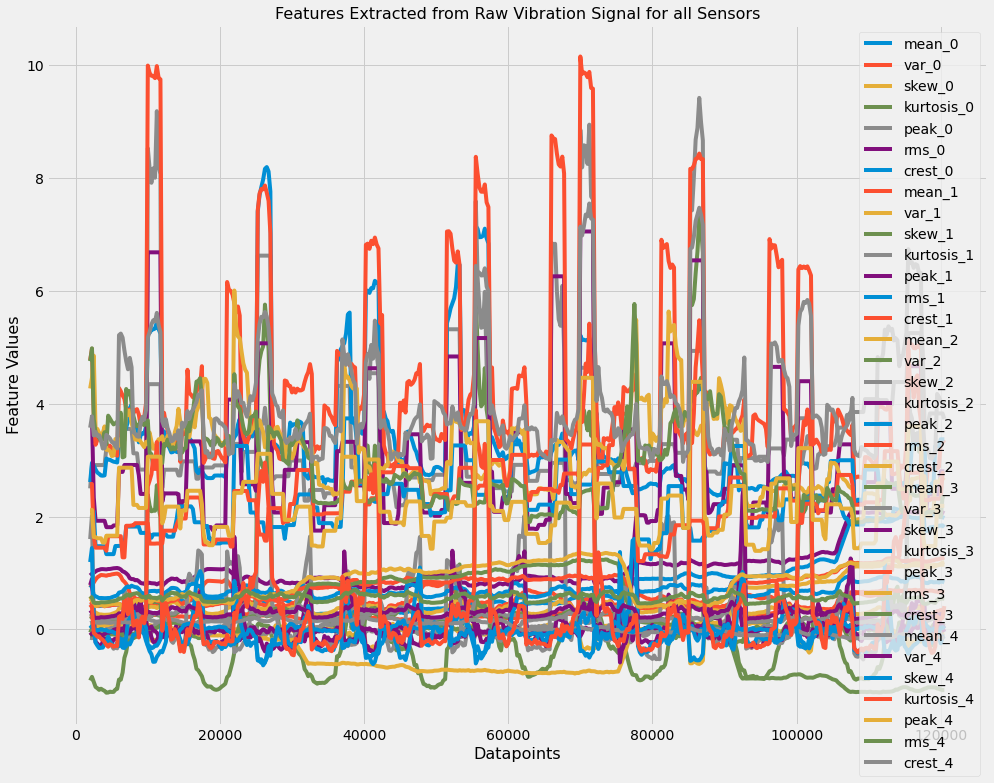

In [41]:
data_new = data_test1_new.iloc[:,5:40]
data_new = pd.concat([data_test_new.loc[:,'DateTime'], data_new], axis=1 )
data_new = data_new.dropna()
print(data_new.shape)
print(data_new.head())
ax=data_new.plot(figsize=(15,12))
ax.set_xlabel('Datapoints', fontsize=16)
ax.set_ylabel('Feature Values', fontsize=16)
ax.set_title('Features Extracted from Raw Vibration Signal for all Sensors', fontsize=16)
plt.show()

In [42]:
data_new_date=data_new[['DateTime']]
data_new_date

,DateTime
1999,2020-02-25 15:03:14.420
2249,2020-02-25 15:03:15.670
2499,2020-02-25 15:03:16.920
2749,2020-02-25 15:03:18.170
2999,2020-02-25 15:03:19.420
...,...
119499,2020-02-25 17:10:36.405
119749,2020-02-25 17:10:37.655
119999,2020-02-25 17:10:38.905
120249,2020-02-25 17:10:40.155


# Feature selection of test set using PCA (reduced to 10 features)

In [43]:
pca = PCA(n_components=10)
fit1 = pca.fit(data_new.iloc[:,1:36])
print("Explained Variance: %s" % fit1.explained_variance_ratio_)
print(fit1.components_)

Explained Variance: [0.67182124 0.10052465 0.06456435 0.04868803 0.03703729 0.03054966
 0.0124597  0.00779039 0.00712756 0.00551598]
[[-1.01286794e-02 -8.37488967e-03 -2.56895265e-02  3.68746003e-01
   1.67727881e-01 -1.30575380e-02  2.19017925e-01 -5.53233274e-04
   6.70656959e-03  2.83050663e-02  5.67787800e-01  3.28000025e-01
   4.26736039e-03  4.39000492e-01 -1.83062662e-02  1.84272447e-03
   1.24478717e-03  7.24340895e-03  3.60763609e-03 -1.76158175e-03
   7.01832749e-03  2.55677482e-02  1.54902818e-03  3.89924884e-04
  -3.35829148e-03  1.04936399e-02  2.25864850e-03  7.95341320e-03
   2.00157615e-03  5.36989919e-03 -3.41846017e-02  2.92399280e-01
   1.51869860e-01  4.93306658e-03  2.28641923e-01]
 [ 3.16199400e-01 -3.64904268e-02 -1.61876035e-02  2.19357384e-01
   2.16745598e-01  2.37476872e-01 -3.50745575e-01  8.56716576e-02
  -1.88822708e-02  8.79671800e-04 -4.08183207e-02 -5.32325733e-02
   3.60798488e-02 -2.64228930e-01  3.85872605e-01 -1.16753173e-02
   9.40793617e-03  9.141

In [44]:
pca = PCA(n_components=10)
data_new = pca.fit_transform(data_new.iloc[:,1:36])
data_new.shape

(475, 10)

In [45]:
data_new = pd.DataFrame(data_new)
data_new.columns=['0','1','2','3','4','5','6','7','8','9']
data_new = pd.concat([data_new_date.loc[:,'DateTime'], data_new.set_index(data_new_date.index)], axis=1, ignore_index=False)
data_new

,DateTime,0,1,2,3,4,5,6,7,8,9
1999,2020-02-25 15:03:14.420,-0.181007,-0.975004,1.720209,1.908015,-1.204089,0.685346,0.035347,-0.918255,0.450052,0.292553
2249,2020-02-25 15:03:15.670,0.347806,-1.091544,1.652484,2.138372,-1.093110,0.928502,-0.026021,-1.030356,0.858917,0.177412
2499,2020-02-25 15:03:16.920,-2.090757,-0.853057,0.290185,1.892000,-0.020265,0.323275,-0.065199,0.664096,0.254925,0.136607
2749,2020-02-25 15:03:18.170,-2.634372,-0.410748,-0.013583,1.358473,0.460703,-0.784458,0.333114,0.195514,0.439036,-0.023987
2999,2020-02-25 15:03:19.420,-2.618138,-0.441757,0.085078,1.320984,0.512849,-0.822057,0.288077,0.230492,0.407591,-0.032207
...,...,...,...,...,...,...,...,...,...,...,...
119499,2020-02-25 17:10:36.405,-2.026233,2.997411,0.217050,-0.526159,0.107975,0.577037,-0.428122,0.432881,-0.021002,-0.156853
119749,2020-02-25 17:10:37.655,-2.058697,2.957654,0.218611,-0.554309,0.169572,0.570022,-0.445462,0.418679,-0.071721,-0.138432
119999,2020-02-25 17:10:38.905,-1.752348,2.801474,0.510242,-0.619789,0.323596,0.771788,-0.435988,0.493970,-0.373415,-0.157069
120249,2020-02-25 17:10:40.155,-1.774525,2.762359,0.495322,-0.568517,0.117049,0.898346,-0.467690,0.063745,-0.425668,-0.196255


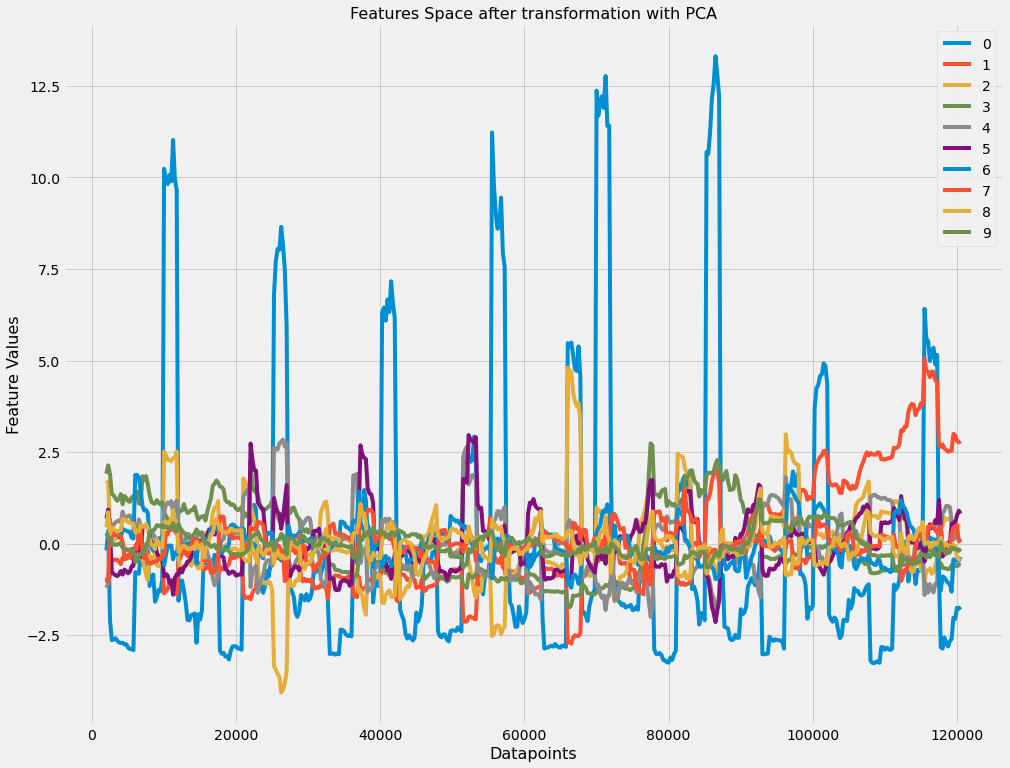

In [46]:
ax=data_new.plot(figsize=(15,12))
ax.set_xlabel('Datapoints', fontsize=16)
ax.set_ylabel('Feature Values', fontsize=16)
ax.set_title('Features Space after transformation with PCA', fontsize=16)
plt.show()

# Correlation matrix visualization

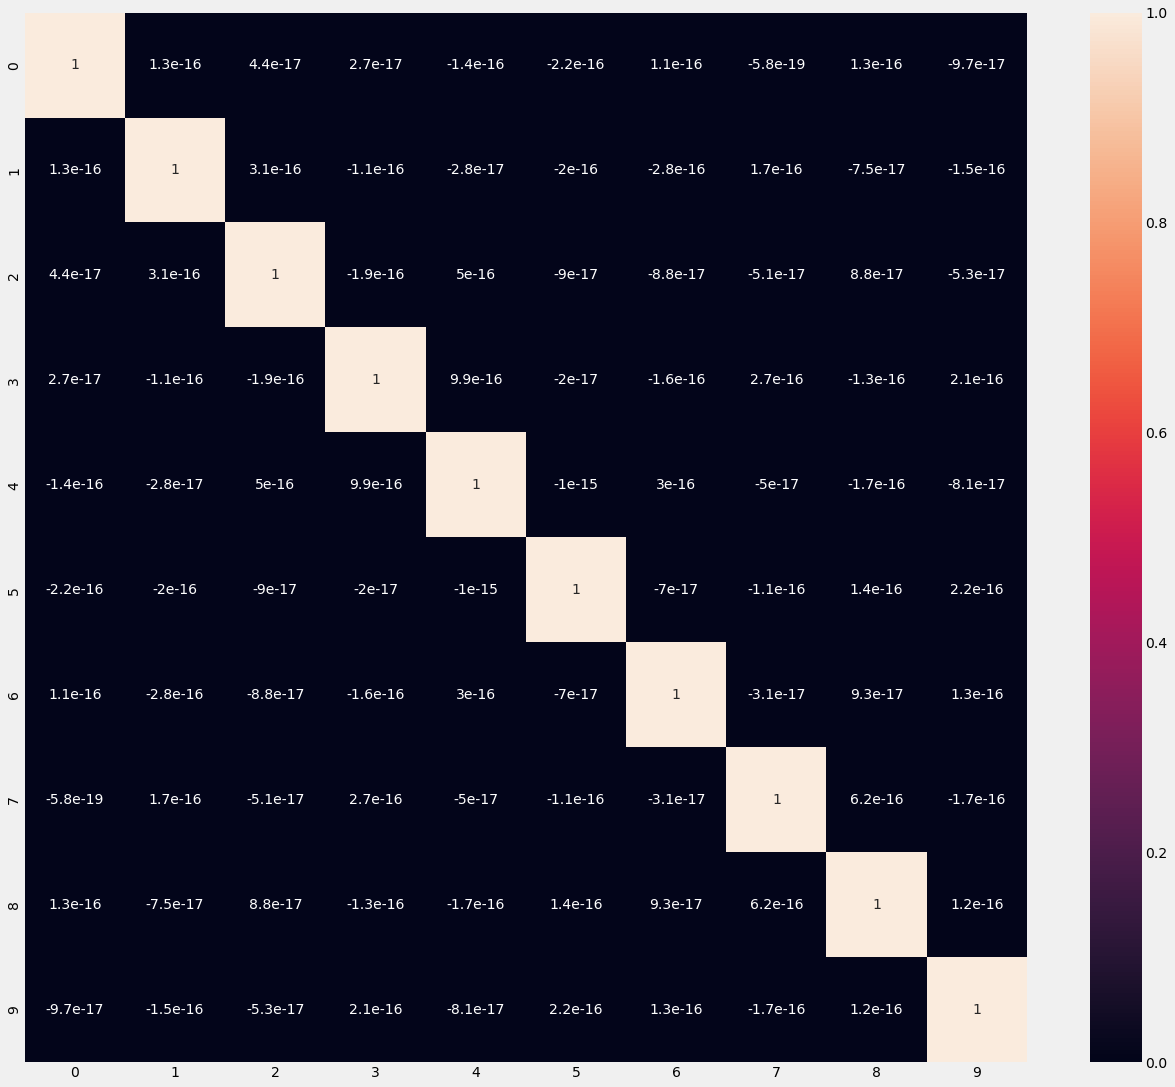

In [48]:
cor_mat_train=data_new.corr(method='pearson')
plt.figure(figsize=(20,18))
import seaborn as sns
sns.heatmap(cor_mat_train, annot=True)
plt.show()

# Mahalanobis distance calculation function

In [49]:
def mahalanobis(x=None, data=None, cov=None):
    """Compute the Mahalanobis Distance between each row of x and the data  
    x    : vector or matrix of data with, say, p columns.
    data : ndarray of the distribution from which Mahalanobis distance of each observation of x is to be computed.
    cov  : covariance matrix (p x p) of the distribution. If None, will be computed from data.
    """
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

# Mahalanobis distance calculation for test set 1 comparing with mean and covariance values of train (reference) set

In [50]:
df_x = data_new[['0','1','2','3','4','5', '6', '7','8','9']]
df_x['mahala'] = mahalanobis(x=df_x, data=data_new[['0','1','2','3','4','5', '6', '7','8','9']])
df_x_asc = df_x.sort_values(by=['mahala'], ascending=False)
df_x_asc

C:\Users\Khyati.Thakkar\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3472: FutureWarning:

In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'



,0,1,2,3,4,5,6,7,8,9,mahala
92749,-0.230501,1.139594,1.229958,0.362813,-1.463276,1.549945,0.368297,0.385233,1.503132,1.202532,37.265236
86499,13.306566,2.086732,-0.789862,2.173762,-1.778552,-2.139813,-0.968632,-0.164763,-0.310566,-0.238204,35.688971
26749,7.496394,-0.661101,-3.803385,0.857823,2.652029,1.150058,-0.370136,-1.026535,-0.414229,-0.014749,34.703103
65999,5.475016,-2.700896,4.801699,-1.711817,0.537641,-1.018335,-1.115255,-0.115318,0.330818,-0.347328,33.955542
26999,5.937095,-0.778213,-3.498593,0.804346,2.754322,1.599436,0.007894,-0.975101,-0.366464,-0.306640,33.617778
...,...,...,...,...,...,...,...,...,...,...,...
15249,-1.830551,-0.516453,-0.642621,0.736923,0.219829,0.012605,0.005309,0.014023,-0.021857,0.309938,2.090123
13749,-1.950515,-0.317780,-0.605563,0.921762,0.123979,-0.368659,-0.012487,-0.005209,-0.149887,0.183917,2.087818
14999,-2.075120,-0.549706,-0.617468,0.720132,0.284103,0.080238,-0.001659,0.004534,-0.088051,0.254388,1.955915
13999,-1.943518,-0.376302,-0.481639,0.912513,0.004326,-0.198549,-0.137999,0.005863,-0.087756,0.216441,1.905516


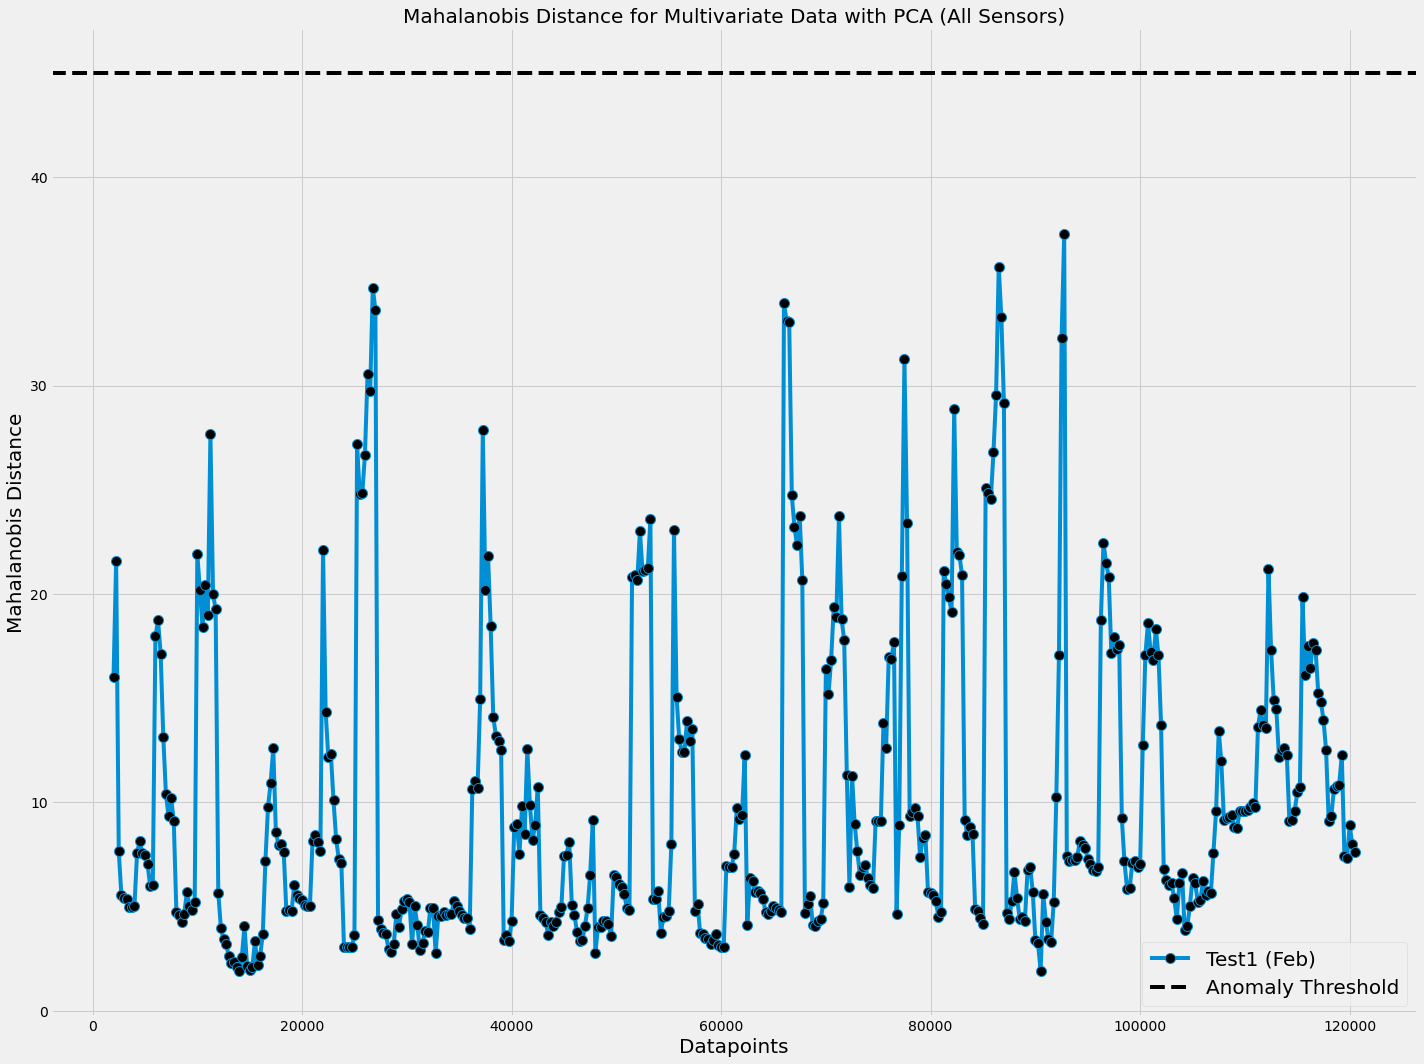

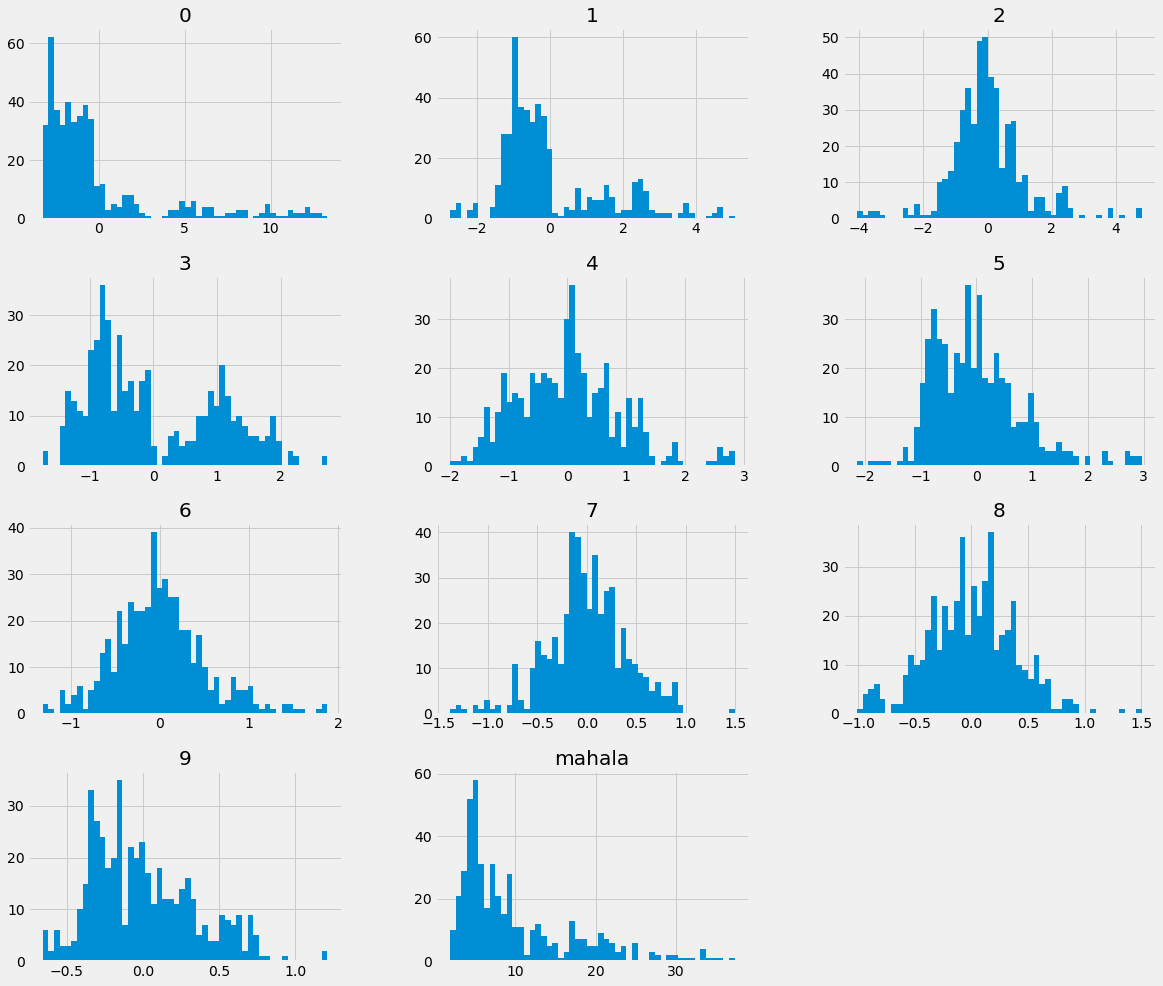

In [51]:
plt.style.use('fivethirtyeight')
ax = df_x['mahala'].plot(figsize=(20,15), marker='o', markersize=10, markerfacecolor='black')
ax.set_xlabel('Datapoints', fontsize=20)
ax.set_ylabel('Mahalanobis Distance', fontsize=20)
ax.set_title('Mahalanobis Distance for Multivariate Data with PCA (All Sensors)', fontsize=20)
ax.legend(fontsize=20)
plt.axhline(45, color='k', linestyle='--')
ax.legend(("Test1 (Feb)", "Anomaly Threshold"), fontsize=20)
plt.tight_layout()

df_x.hist(bins=50, figsize=(18,16))
plt.show()

C:\Users\Khyati.Thakkar\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



Text(0.5, 0, 'Mahalanobis dist')

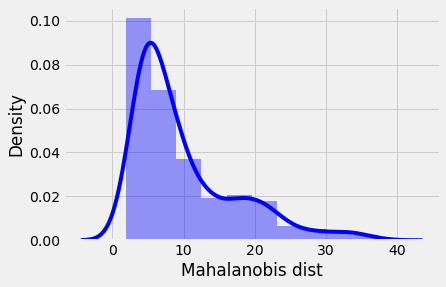

In [52]:
plt.figure()
sns.distplot(df_x['mahala'],
             bins = 10, 
             kde= True, 
            color = 'blue');
plt.xlabel('Mahalanobis dist')

In [54]:
feb = df_x[['mahala']]
feb.columns = ['Feb_Maha']
feb

,Feb_Maha
1999,15.999763
2249,21.573678
2499,7.667827
2749,5.544560
2999,5.428024
...,...
119499,7.427778
119749,7.333395
119999,8.904829
120249,7.992850


In [81]:
feb.to_csv("Output_Data_Files/Multivariate_MahaDist_Smooth_With PCA_Feb.csv")
feb

,Feb_Maha
1999,15.999763
2249,21.573678
2499,7.667827
2749,5.544560
2999,5.428024
...,...
119499,7.427778
119749,7.333395
119999,8.904829
120249,7.992850


# Similar analysis is done for March data refered to as test2 data to derive mahalanobis distances for each sensor values in test 2 dataset and is used in further analysis for comparison between test 1 and test 2 datasets

# Compare & plot mahalanobis distances for both test sets (test 1 & test 2)

In [82]:
test1 = pd.read_csv('Output_Data_Files/Multivariate_MahaDist_Smooth_With PCA_Feb.csv', index_col=0)
test1

,Feb_Maha
1999,15.999763
2249,21.573678
2499,7.667827
2749,5.544560
2999,5.428024
...,...
119499,7.427778
119749,7.333395
119999,8.904829
120249,7.992850


In [83]:
test2 = pd.read_csv('Output_Data_Files/Multivariate_MahaDist_Smooth_With PCA_March.csv', index_col=0)
test2

,March_Maha
1999,24.902460
2249,19.873150
2499,10.998446
2749,11.863386
2999,12.190402
...,...
120999,27.144797
121249,27.650644
121499,27.719643
121749,27.912206


In [58]:
Maha_both = pd.concat([test1,test2], axis=1)
Maha_both

,Feb_Maha,March_Maha
1999,15.999763,24.902460
2249,21.573678,19.873150
2499,7.667827,10.998446
2749,5.544560,11.863386
2999,5.428024,12.190402
...,...,...
120999,NaN,27.144797
121249,NaN,27.650644
121499,NaN,27.719643
121749,NaN,27.912206


In [59]:
Maha_both.columns =['Test1 (Feb)', 'Test2 (March)']

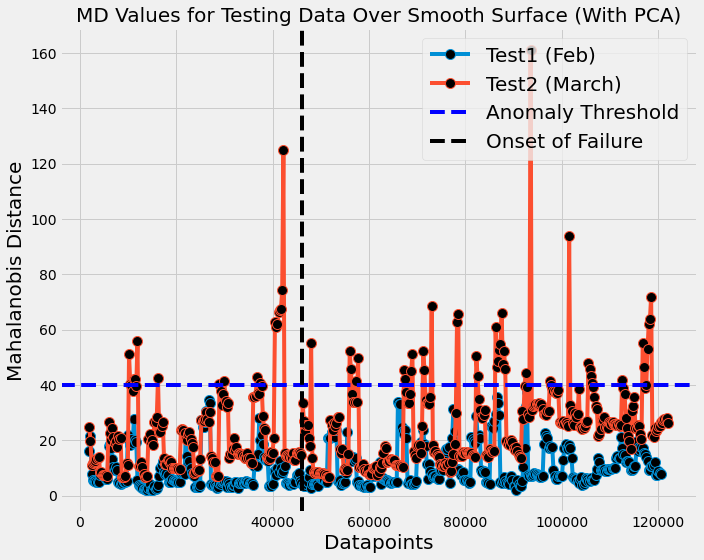

In [61]:
plt.style.use('fivethirtyeight')
ax = Maha_both.plot(figsize=(10,8), marker='o', markersize=10, markerfacecolor='black')
ax.set_xlabel('Datapoints', fontsize=20)
ax.set_ylabel('Mahalanobis Distance', fontsize=20)
ax.set_title('MD Values for Testing Data Over Smooth Surface (With PCA)', fontsize=20)
ax.legend(fontsize=20)
plt.axhline(40, color='blue', linestyle='--')
plt.axvline(46040, color='black', linestyle='--')
ax.legend(("Test1 (Feb)", "Test2 (March)", "Anomaly Threshold", "Onset of Failure"), fontsize=20)
plt.tight_layout()